<a href="https://colab.research.google.com/github/dBenazzi/progetto-2023-data-intensive/blob/main/motorbike_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# predizione prezzo di vendita di motocicli  
*progetto programmazione di applicazioni data intensive*  
Daniel Benazzi - daniel.benazzi@studio.unibo.it

# introduzione

I dati presi in esame riguardano la vendita, di circa 32.000 motociclette usate, in India nell'anno 2015.  
Si cerca di prevedere il **prezzo** di vendita.  
Il dataset puo essere scaricato da [Kaggle](https://www.kaggle.com/datasets/saisaathvik/used-bikes-prices-in-india?datasetId=1381603) e i dati originano da un sito per la compravendita di veicoli ([droom.in](https://www.droom.in) )

segue l'installazione e l'import di alcune librerie, la definizione di alcune constanti e lo scaricamento dei dati

In [ ]:
# !pip install requests # libreria per il download dei dati
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [ ]:
_FILE_PATH = "./used-bikes.zip"
_FILE_URL = "https://github.com/dBenazzi/progetto-2023-data-intensive/raw/main/used-bikes.zip"

_RANDOM_STATE = 19
_TEST_SIZE = 1/3
_N_SPLITS = 5

In [ ]:
from os.path import exists

# download file
if not exists(_FILE_PATH):
  import requests
  open(_FILE_PATH, "wb").write(requests.get(_FILE_URL).content)

data = pd.read_csv(_FILE_PATH, sep=",", compression="zip")

# Analisi dei dati

In [ ]:
data.head(5)

,bike_name,price,city,kms_driven,owner,age,power,brand
0,TVS Star City Plus Dual Tone 110cc,35000.0,Ahmedabad,17654.0,First Owner,3.0,110.0,TVS
1,Royal Enfield Classic 350cc,119900.0,Delhi,11000.0,First Owner,4.0,350.0,Royal Enfield
2,Triumph Daytona 675R,600000.0,Delhi,110.0,First Owner,8.0,675.0,Triumph
3,TVS Apache RTR 180cc,65000.0,Bangalore,16329.0,First Owner,4.0,180.0,TVS
4,Yamaha FZ S V 2.0 150cc-Ltd. Edition,80000.0,Bangalore,10000.0,First Owner,3.0,150.0,Yamaha


### caratteristiche delle colonne
- *bike_name*: nome e descrizione modello (stringa)
- *price*: prezzo di rivendita in rupie indiane (float)
- *city*: città di messa in vendita (stringa)
- *kms_driven*: numero di Km della moto (float)
- *owner*: indica il numero di proprietari precedenti (stringa)
- *age*: anni della moto (int)
- *power*: volume in cm^3 del motore (float)
- *brand*: nome del produttore (stringa)


In [ ]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32648 entries, 0 to 32647
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bike_name   32648 non-null  object 
 1   price       32648 non-null  float64
 2   city        32648 non-null  object 
 3   kms_driven  32648 non-null  float64
 4   owner       32648 non-null  object 
 5   age         32648 non-null  float64
 6   power       32648 non-null  float64
 7   brand       32648 non-null  object 
dtypes: float64(4), object(4)
memory usage: 9.5 MB


Come si può vedere i dati sono stati caricati come tipi `float` e `Object`.
Questi possono essere modificati per permettere un accesso più efficiente durante l'utilizzo del dataframe.  
In particolare i dati indicati sopra come stringa sono nominali, questo vuol dire che possono assumere solo un numero limitato di valori, pur essendo stringhe, in Pandas vengono definiti `Categorical`.  
Si procede a creare un nuovo dataframe con il tipo di dato aggiornato.

In [ ]:
dtypes_map = {
    "age": "int",
    "bike_name": "category",
    "city": "category",
    "owner": "category",
    "brand": "category"
}
full_data = pd.read_csv(_FILE_PATH, sep=",", compression="zip", dtype=dtypes_map)
full_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32648 entries, 0 to 32647
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   bike_name   32648 non-null  category
 1   price       32648 non-null  float64 
 2   city        32648 non-null  category
 3   kms_driven  32648 non-null  float64 
 4   owner       32648 non-null  category
 5   age         32648 non-null  int64   
 6   power       32648 non-null  float64 
 7   brand       32648 non-null  category
dtypes: category(4), float64(3), int64(1)
memory usage: 1.3 MB


## Esplorazione dei dati
Si esegue un'analisi dei dati al fine di capire: come manipolarli nella fase di processamento e quali siano i più rilevanti per i modelli che verranno addestrati.

In [ ]:
numerical = ["price", "kms_driven", "age", "power"]
categorical = ["bike_name", "city", "owner", "brand"]

### dati numerici
Si procede con l'analisi della distribuzione dei dati di tipo numerico

In [ ]:
def numerical_hist_subplot(x, y, columns, titles, xlabels, scale):
    n = len(columns)
    plt.figure(figsize=(15,10))
    for i in range(0,n):
      plt.subplot(x, y, i+1)
      plt.hist(full_data[columns[i]], log=scale[i], rwidth=0.8)
      plt.title(titles[i])
      plt.xlabel(xlabels[i])

def numerical_box_subplot(x, y, columns, titles, xlabels):
    n = len(columns)
    plt.figure(figsize=(15,10))
    for i in range(0,n):
      plt.subplot(x, y, i+1)
      plt.boxplot(full_data[columns[i]], vert=False)
      plt.title(titles[i])
      plt.xlabel(xlabels[i])

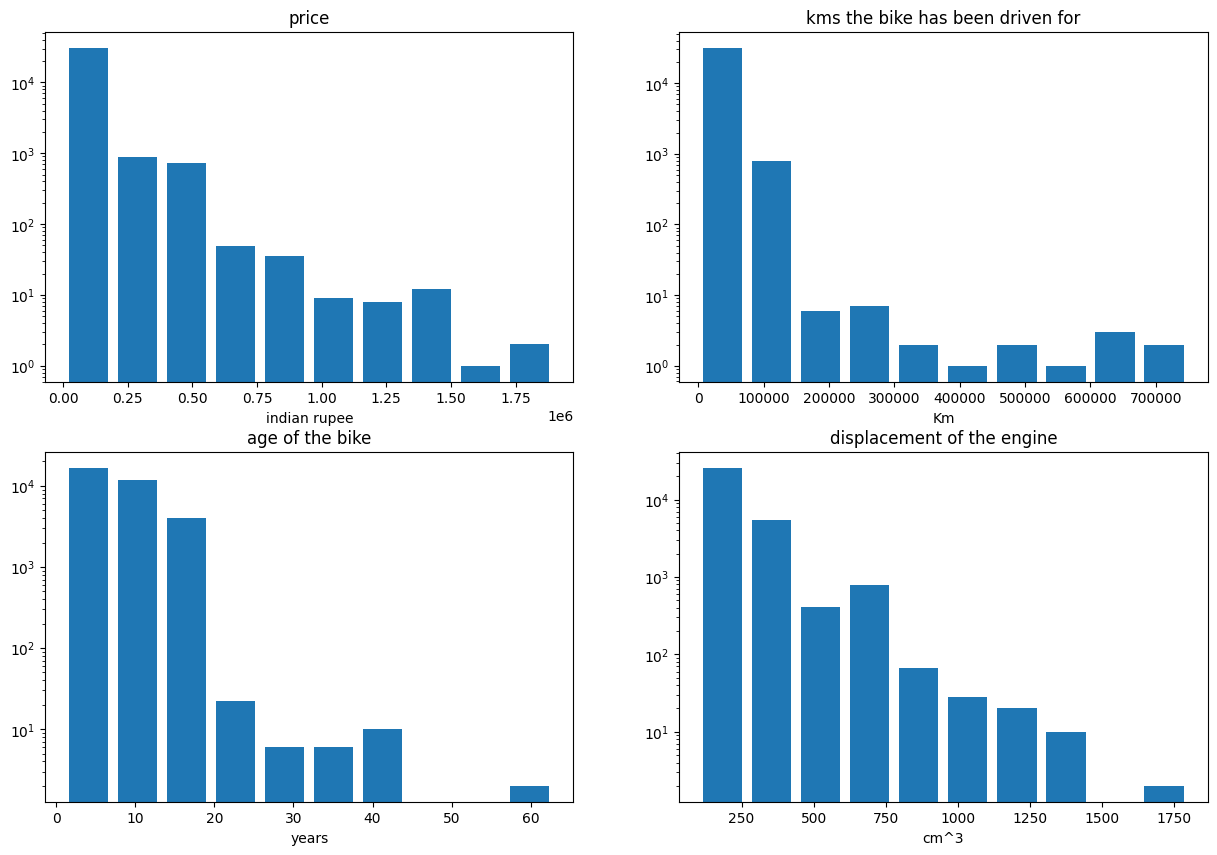

In [ ]:
numerical_hist_subplot(2, 2,
                      numerical, 
                      ["price", "kms the bike has been driven for", "age of the bike", "displacement of the engine"],
                      ["indian rupee", "Km", "years", "cm^3"],
                      [True, True, True, True])

I grafici mostrano la distribuzione dei dati con una **scala logaritmica** lungo l'asse y.  
possiamo quindi notare come le distribuzioni siano sbilanciate verso valori "**bassi**" delle features mostrate.  

In fase di preprocessamento potranno essere eliminati dei dati appartenenti all'estremo superiore al fine di migliorare l'addestramento dei modelli.  
Avendo molti valori lontani dal valore medio non potrà essere usata la normalizzazione dei dati; rimane possibile applicare la standardizzazione.

Si analizza ora la distribuzione dei dati attraverso dei boxplot

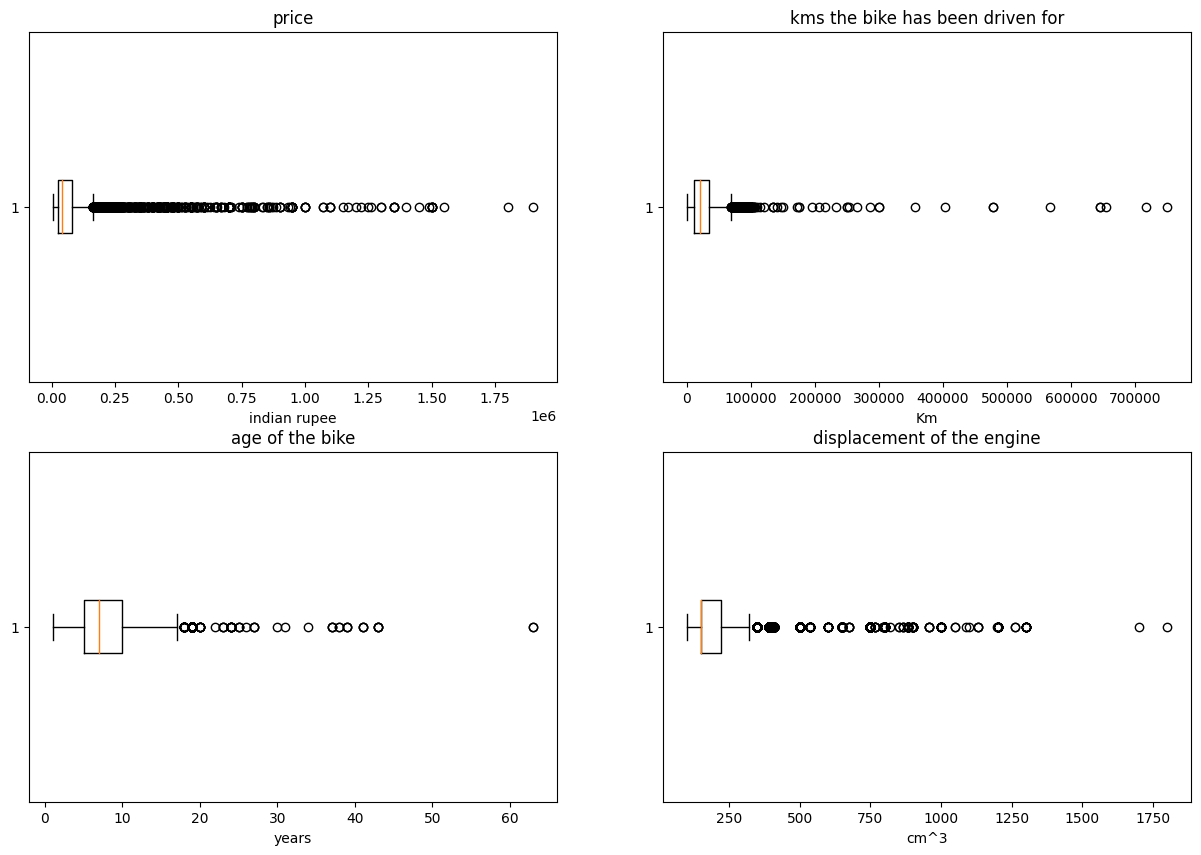

In [ ]:
numerical_box_subplot(2, 2,
                      numerical, 
                      ["price", "kms the bike has been driven for", "age of the bike", "displacement of the engine"],
                      ["indian rupee", "Km", "years", "cm^3"])

I boxplot confermano come la distribuzione dei dati non sia di tipo normale.  
Va sottolineato che i dati mostrati come *outliars* nel box plot (fatta eccezzione per i casi estremi) non possano essere considerati veramente come tali, quindi rimuovendoli dal dataset per l'addestramento, le previsioni non sarebbero veritiere.

Si può tuttavia mostrare la percentuale dei valori appartenenti all'intervallo `[media-dev. standard ; media+dev. standard]` per conoscerne meglio la distribuzione

In [ ]:
info = full_data[numerical].agg(["count", "mean", "std"])
row_c = {}
row_p = {}
for col in numerical:
  serie = full_data[col]
  mean = serie.mean()
  std = serie.std()
  count = (serie <= (mean+std)) & (serie >= (mean-std))
  row_p[col] = count.sum()/len(serie)
  row_c[col] = count.sum()
info.loc["count in std range"] = row_c
info.loc["percentange in std range"] = row_p
info

,price,kms_driven,age,power
count,32648.000000,32648.000000,32648.000000,32648.000000
mean,68295.417637,26344.625184,8.048211,213.511302
std,90718.595205,22208.527695,4.031700,134.428868
count in std range,30649.000000,24865.000000,20750.000000,25993.000000
percentange in std range,0.938771,0.761609,0.635567,0.796159


### dati nominali
Si procede con l'analisi dei dati di tipo nominale

In [ ]:
full_data[categorical].describe()

,bike_name,city,owner,brand
count,32648,32648,32648,32648
unique,471,443,4,23
top,Bajaj Pulsar 150cc,Delhi,First Owner,Bajaj
freq,2776,7318,29964,11213


Si può vedere come nel dataset siano presenti `471` modelli di motociclette da `23` marchi, venduti in `443` città.  
La maggioranza delle motociclette hanno avuto un unico proprietario precedente, come si può notare dalle percentuali nella tabella sotto.

La colonna *bike_name* non verrà usata per la previsione, in quanto le informazioni sono le stesse presenti in altre colonne, sarà quindi scartata nella fase di preprocessamento.  
Prima di scartare la colonna *city* si dovrà verificare se la città di vendita influisce sul prezzo controllandone la correlazione.  
Lo stesso discorso vale per la colonna *brand*.

In [ ]:
owners = full_data["owner"].value_counts(normalize=True)
pd.DataFrame(owners)

,owner
First Owner,0.917790
Second Owner,0.078535
Third Owner,0.003308
Fourth Owner Or More,0.000368


### correlazione tra i dati
Si procede a verificare come i dati numerici siano legati al prezzo di vendita

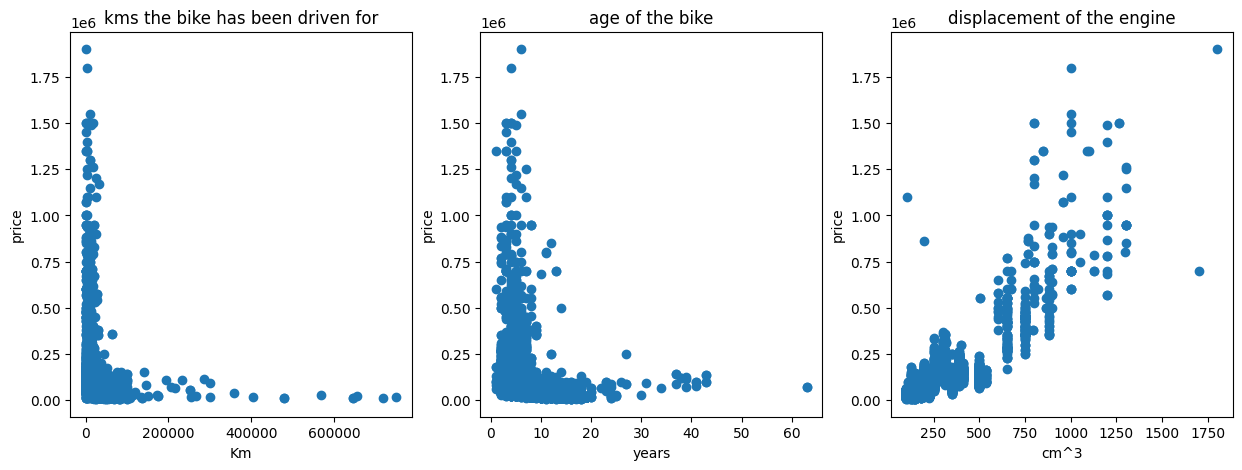

In [ ]:
def price_on_numerical_subplot(x, y, columns, titles, xlabels):
    n = len(columns)
    plt.figure(figsize=(15,5))
    for i in range(0,n):
      plt.subplot(x, y, i+1)
      plt.scatter(full_data[columns[i]], full_data["price"] )
      plt.title(titles[i])
      plt.xlabel(xlabels[i])
      plt.ylabel("price")

price_on_numerical_subplot(1, 3,
                          ['kms_driven', 'age', 'power'], 
                          ["kms the bike has been driven for", "age of the bike", "displacement of the engine"],
                          ["Km", "years", "cm^3"])

Si nota come il *chilometraggio* della moto e gli *anni* non influiscano direttamente sul prezzo di vendita della moto, se non dopo una certa soglia abbassandolo, sarà interessante notare come i modelli regoleranno i pesi sul dato.  
Si nota anche come queste due caratteristiche siano correlate; sarà utile usare modelli **regolarizzati** per migliorare la stabilità delle previsioni.

Si può vedere invece come la *dimensione del motore* ed il *prezzo* sono direttamente dipendenti. 

si passa ad analizzare la correlazione `marca - costo` e `città di vendita - costo`

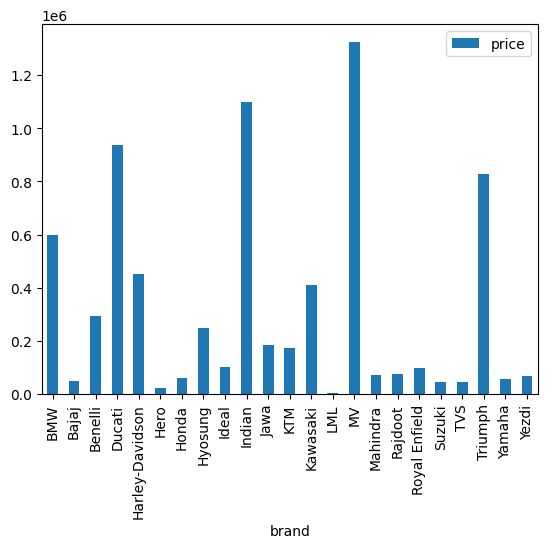

In [ ]:
_ = full_data[["brand", "price"]].groupby("brand").mean().plot.bar()

Si vede come il prezzo medio per alcune case sia più alto.  
Va però fatto notare che alcune marche hanno pochi dati di vendita; queste non sono utilizzabili per una previsione affidabile ed andranno scartate. infatti:

In [ ]:
full_data["brand"].value_counts(ascending=True)

Yezdi                  1
Rajdoot                1
LML                    1
Ideal                  2
Indian                 3
MV                     4
Jawa                  10
BMW                   16
Ducati                22
Triumph               26
Mahindra              55
Benelli               56
Hyosung               64
Kawasaki              79
Harley-Davidson      737
KTM                 1077
TVS                 1247
Suzuki              1464
Honda               2108
Yamaha              3916
Royal Enfield       4178
Hero                6368
Bajaj              11213
Name: brand, dtype: int64

per quanto riguarda le **città di vendita** molte di queste hanno un numero troppo piccolo di dati per essere considerate;  
infatti 401 su 443 hanno meno di 20 dati di vendita.

In [ ]:
(full_data[["city", "price"]].groupby("city").count() < 20).sum()

price    401
dtype: int64

# Preprocessamento
In questa fase si procede a:
1. controllo dei dati NAN
2. Eliminare le colonne non rilevanti dal dataframe. In particolare si scartano `bike_name` e `city` 
3. Eliminare i dati di vendita per le case produttrici con un numero di vendite < 10
4. Rimozione dei dati di vendita con costi estremi
5. selezione porzione casuale dei dati per l'addestramento e divisione in fold
6. Trasformazione variabili categoriche rimaste



In [ ]:
full_data.isna().sum()

bike_name     0
price         0
city          0
kms_driven    0
owner         0
age           0
power         0
brand         0
dtype: int64

In questo dataset non sono presenti valori nulli. Si continua con la trasformazione dei dati

In [ ]:
model_data = full_data.drop(columns=["bike_name", "city"])
model_data.head()

,price,kms_driven,owner,age,power,brand
0,35000.0,17654.0,First Owner,3,110.0,TVS
1,119900.0,11000.0,First Owner,4,350.0,Royal Enfield
2,600000.0,110.0,First Owner,8,675.0,Triumph
3,65000.0,16329.0,First Owner,4,180.0,TVS
4,80000.0,10000.0,First Owner,3,150.0,Yamaha


In [ ]:
categorical_left = ["owner", "brand"]

Queste sono le colonne rimaste per lavorare sulla previsione.

In [ ]:
brands = model_data["brand"].value_counts() < 10
brands = brands[brands].index.tolist() # list of brands with less than 10 bikes sold
brands = model_data[model_data["brand"].isin(brands)].index.tolist() # indexes num. of sold bike from those brands
model_data.drop(index=brands, inplace=True)
print("numero righe eliminate: ", len(brands), "\n")
model_data.info(verbose=False)

numero righe eliminate:  12 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32636 entries, 0 to 32647
Columns: 6 entries, price to brand
dtypes: category(2), float64(3), int64(1)
memory usage: 1.3 MB


Sono stati eliminati i dati di vendita per le case produttrici con poche informazioni. (**meno di 10 righe**)

Si procede ora ad eliminare i dati con un prezzo di vendita appartente a "casi limite".  
Per fare questo si utilizza lo **z-score**.

Lo z-score viene calcolato, per ogni prezzo di vendita, come: `[(valore i) - mean] / std`. Con:
- `mean`: media del prezzo di vendita
- `std`: deviazione standard del prezzo di vendita  
Indica pertanto uno punteggio di "scostamento" dalla media medi valori.

Verranno eliminati i valori con z-score **>= 6.5**

In [ ]:
mean =  model_data["price"].mean()
std = model_data["price"].std()
z_score = (model_data["price"] - mean) / std
model_data.drop(index=model_data[z_score > 4].index, inplace=True)
el_num, total_num = (z_score >= 6.5).sum(), full_data["price"].count() 
print("numero valori eliminati: ", el_num)
print(f"ovvero il: {el_num / total_num:.4f}% rispetto al numero di valori iniziali")

numero valori eliminati:  92
ovvero il: 0.0028% rispetto al numero di valori iniziali


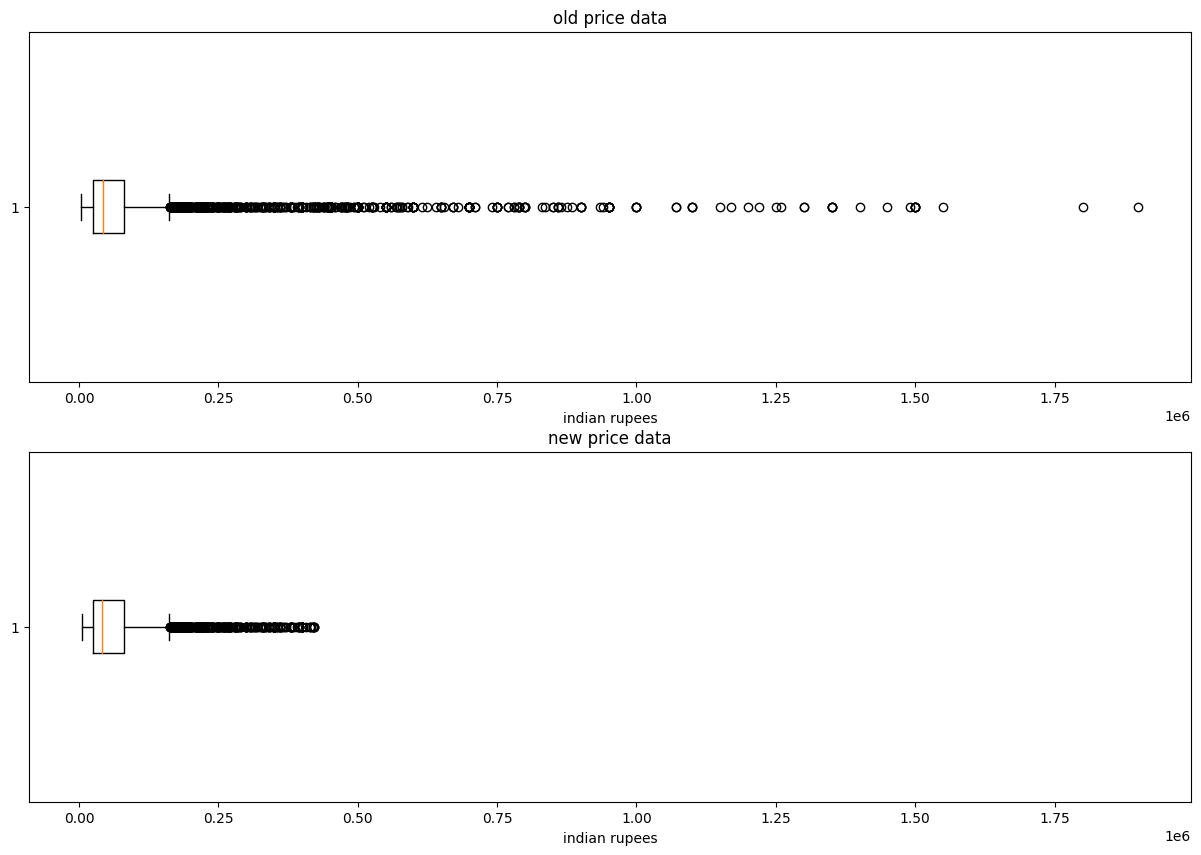

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.boxplot(full_data["price"], vert=False)
plt.title("old price data")
plt.xlabel("indian rupees")
limit = plt.xlim()

plt.subplot(2, 1, 2)
plt.boxplot(model_data["price"], vert=False)
plt.title("new price data")
plt.xlabel("indian rupees")
_ = plt.xlim(limit)

Si puo vedere il confronto tra il box plot dei dati prima e dopo aver scartato i valori in base allo z-score

si procede a dividere i dati in training e validation set con il metodo **hold-out**.

In [ ]:
from sklearn.model_selection import train_test_split
x = model_data.drop(columns="price")
y = model_data["price"]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=_TEST_SIZE, random_state=_RANDOM_STATE)

si procede a trasformare le variabili categoriche del dataset

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

owner_categories = full_data["owner"].unique().tolist()
brand_categories = full_data["brand"].cat.categories.tolist()

ordinal = OrdinalEncoder(categories=[owner_categories], dtype="int")
onehot = OneHotEncoder(categories=[brand_categories], sparse_output=False, dtype="int")

In [ ]:
# transform owner column in training and test data
data = x_train["owner"].values.reshape(-1, 1)
x_train["owner"] = ordinal.fit_transform(data)

data = x_val["owner"].values.reshape(-1, 1)
x_val["owner"] = ordinal.fit_transform(data)

In [ ]:
# one hot encoding of column "brand" in training and test data
data = x_train["brand"].values.reshape(-1, 1)
data = onehot.fit_transform(data)
names = onehot.categories_[0]
x_train[names] = data
x_train.drop(columns="brand", inplace=True)

data = x_val["brand"].values.reshape(-1, 1)
data = onehot.fit_transform(data)
names = onehot.categories_[0]
x_val[names] = data
x_val.drop(columns="brand", inplace=True)

In [ ]:
x_train.head(1)

,kms_driven,owner,age,power,BMW,Bajaj,Benelli,Ducati,Harley-Davidson,Hero,...,LML,MV,Mahindra,Rajdoot,Royal Enfield,Suzuki,TVS,Triumph,Yamaha,Yezdi
4618,6087.0,0,4,100.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_val.head(1)

,kms_driven,owner,age,power,BMW,Bajaj,Benelli,Ducati,Harley-Davidson,Hero,...,LML,MV,Mahindra,Rajdoot,Royal Enfield,Suzuki,TVS,Triumph,Yamaha,Yezdi
17217,20373.0,0,6,220.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


dopo la trasformazione delle colonne categoriche i dati sono pronti per esssere usati nell'addestramento dei modelli.

In [ ]:
x_numerical = ["kms_driven", "owner", "age", "power"]
x_bool = x_val.drop(columns=x_numerical).columns.tolist()
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10606 entries, 17217 to 6685
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kms_driven       10606 non-null  float64
 1   owner            10606 non-null  int64  
 2   age              10606 non-null  int64  
 3   power            10606 non-null  float64
 4   BMW              10606 non-null  int64  
 5   Bajaj            10606 non-null  int64  
 6   Benelli          10606 non-null  int64  
 7   Ducati           10606 non-null  int64  
 8   Harley-Davidson  10606 non-null  int64  
 9   Hero             10606 non-null  int64  
 10  Honda            10606 non-null  int64  
 11  Hyosung          10606 non-null  int64  
 12  Ideal            10606 non-null  int64  
 13  Indian           10606 non-null  int64  
 14  Jawa             10606 non-null  int64  
 15  KTM              10606 non-null  int64  
 16  Kawasaki         10606 non-null  int64  
 17  LML      

# addestramento modelli

si procede ad addestrare alcuni modelli di regressione per poi confrontarne i loro punteggi.  
Ogni modello verrà addestrato attraverso una **grid search** per la ricerca degli iperparametri.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, PolynomialFeatures

kf = KFold(n_splits=_N_SPLITS, shuffle=True, random_state=_RANDOM_STATE)

In [ ]:
def print_scores(y_pred, y_true):
  r2 = r2_score(y_pred=y_pred, y_true=y_true)
  mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
  re = np.mean(np.abs(1-(y_pred/y_true))) 
  print(f"r2 score: {r2:.4f}, mean squared error: {mse:.4f}, relative error: {re:.4f}")

## Modello lineare 

Si procede alla creazione di un modello lineare semplice. Questo verrà usato come modello di base per il confronto con gli altri modelli.

In [ ]:
lin_mdl = LinearRegression(n_jobs=-1)
lin_score = cross_val_score(lin_mdl, x_train, y_train, scoring="r2", cv=kf).mean()
lin_mdl.fit(x_train, y_train)
print("mean r2 score on train data: ", lin_score, "\n\nscores on test data:")
print_scores(lin_mdl.predict(x_val), y_val)

print("\n\n coefficients: ", lin_mdl.coef_)
print("intercept: ", lin_mdl.intercept_)

mean r2 score on train data:  0.8873222737372719 

scores on test data:
r2 score: 0.8896, mean squared error: 237764225.5537, relative error: 0.2925


 coefficients:  [-1.91339227e-01 -2.25709939e+03 -2.77812577e+03  3.39815578e+02
  1.28721777e+05 -6.40238665e+04  5.63024252e+04  6.65703285e+04
  4.90779243e+04 -5.36690720e+04 -4.66407103e+04  4.86169664e+04
  4.52928361e-10 -1.16415322e-10  3.95582068e+04 -2.90059204e+03
  6.94565521e+04 -2.91038305e-11  0.00000000e+00 -5.06267950e+04
  0.00000000e+00 -7.61938240e+04 -5.18609041e+04 -6.49841334e+04
  0.00000000e+00 -4.74042835e+04  0.00000000e+00]
intercept:  73871.11913878821


Si procede a verificare se una **standardizzzazione** dei dati in aggiunta al modello lineare migliori o meno le prestazioni. 

In [ ]:
scaler = ColumnTransformer([
    ("scaler", RobustScaler(), x_numerical)
], remainder="passthrough")
lin_scaled_model = Pipeline([
    ("scaler", scaler),
    ("model", LinearRegression())
])

scaled_score = cross_val_score(lin_scaled_model, x_train, y_train, scoring="r2", cv=kf).mean()
print("mean r2 score on train data: ", scaled_score, "\n\nscores on test data:")
lin_scaled_model.fit(x_train, y_train)
print_scores(lin_scaled_model.predict(x_val), y_val)

print("\n\n coefficients: ", lin_scaled_model.named_steps["model"].coef_)
print("intercept: ", lin_scaled_model.named_steps["model"].intercept_)

mean r2 score on train data:  0.887322273737263 

scores on test data:
r2 score: 0.8896, mean squared error: 237764225.5537, relative error: 0.2925


 coefficients:  [-4.35947295e+03 -2.25709939e+03 -1.38906289e+04  2.88843242e+04
  1.28721777e+05 -6.40238665e+04  5.63024252e+04  6.65703285e+04
  4.90779243e+04 -5.36690720e+04 -4.66407103e+04  4.86169664e+04
  2.91038305e-11  2.18278728e-11  3.95582068e+04 -2.90059204e+03
  6.94565521e+04 -5.82076609e-11 -2.27373675e-12 -5.06267950e+04
  0.00000000e+00 -7.61938240e+04 -5.18609041e+04 -6.49841334e+04
  0.00000000e+00 -4.74042835e+04  0.00000000e+00]
intercept:  101426.28652418769


Come si può vedere non ci sono miglioramenti apprezzabili delle previsioni del modello.  
Verrà, per questo, usato il modello lineare semplice per i confronti.

## Modelli polinomiali
Segue la crezione ed il confronto di alcuni modelli polinomiali:
- modello polinomiale semplice
- modello polinomiale con standardizzazione dei dati
- modello polinomiale con standardizzazione e penalizzazione dei coefficienti

I modelli iniziali verranno creati usando i parametri preimpostati al fine di stimare quale sia migliore.
Il modello scelto sarà poi riaddestrato con una ricerca dei parametri.

### modello polinomiale lineare
Segue la creazione di un modello lineare semplice e la stampa dei dati generati dal filtro polinomiale.  
Senza specificare parametri vengono generati i dati fino al secondo grado.

I dati di tipo categorico **non** vengono modificati dalla trasformazione.

In [ ]:
poly = ColumnTransformer([
    ("poly", PolynomialFeatures(include_bias=False), x_numerical)
], remainder="passthrough")
pol_lin_model = Pipeline([
    ("poly", poly),
    ("model", LinearRegression())
])

pol_score = cross_val_score(pol_lin_model, x_train, y_train, scoring="r2", cv=kf).mean()
print("mean r2 score on train data: ", pol_score, "\n\nscores on test data:")

pol_lin_model.fit(x_train, y_train)
print_scores(pol_lin_model.predict(x_val), y_val)

mean r2 score on train data:  0.921992642887535 

scores on test data:
r2 score: 0.9277, mean squared error: 155830089.1448, relative error: 0.1867


In [ ]:
# columns generated by PolynomialFeatures
pol_lin_model.named_steps["poly"].transformers_[0][1].get_feature_names_out().tolist()

['kms_driven',
 'owner',
 'age',
 'power',
 'kms_driven^2',
 'kms_driven owner',
 'kms_driven age',
 'kms_driven power',
 'owner^2',
 'owner age',
 'owner power',
 'age^2',
 'age power',
 'power^2']

### modello polinomiale lineare con standardizzazione delle feature
Segue la creazione di un modello polinomiale con standardizzzazione (e centratura) dei dati in input.  
La standardizzazione avviene grazie al filtro `RobustScaler`, una versione di `StandardScaler` meno suscettibile a valori erratici (outliers), che non usa la deviazione standard ma la diferenza tra gli estremi del 1° e 3° quartile (*IQR*) per ridimensionare i dati.

Il grado dei termini generati rimane il 2°.

In [ ]:
poly_std = ColumnTransformer([
    ("poly", PolynomialFeatures(include_bias=False), x_numerical),
    ("scaler", RobustScaler(), x_numerical)
], remainder="passthrough")
pol_scale_model = Pipeline([
    ("scaler", poly_std),
    ("model", LinearRegression())
])

pol_scale_score = cross_val_score(pol_scale_model, x_train, y_train, scoring="r2", cv=kf).mean()
print("mean r2 score on train data: ", pol_scale_score, "\n\nscores on test data:")

pol_scale_model.fit(x_train, y_train)
print_scores(pol_scale_model.predict(x_val), y_val)

mean r2 score on train data:  0.9219926491541734 

scores on test data:
r2 score: 0.9277, mean squared error: 155830100.4112, relative error: 0.1867


Text(0.5, 1.0, 'polinomial model coefficients comparison')

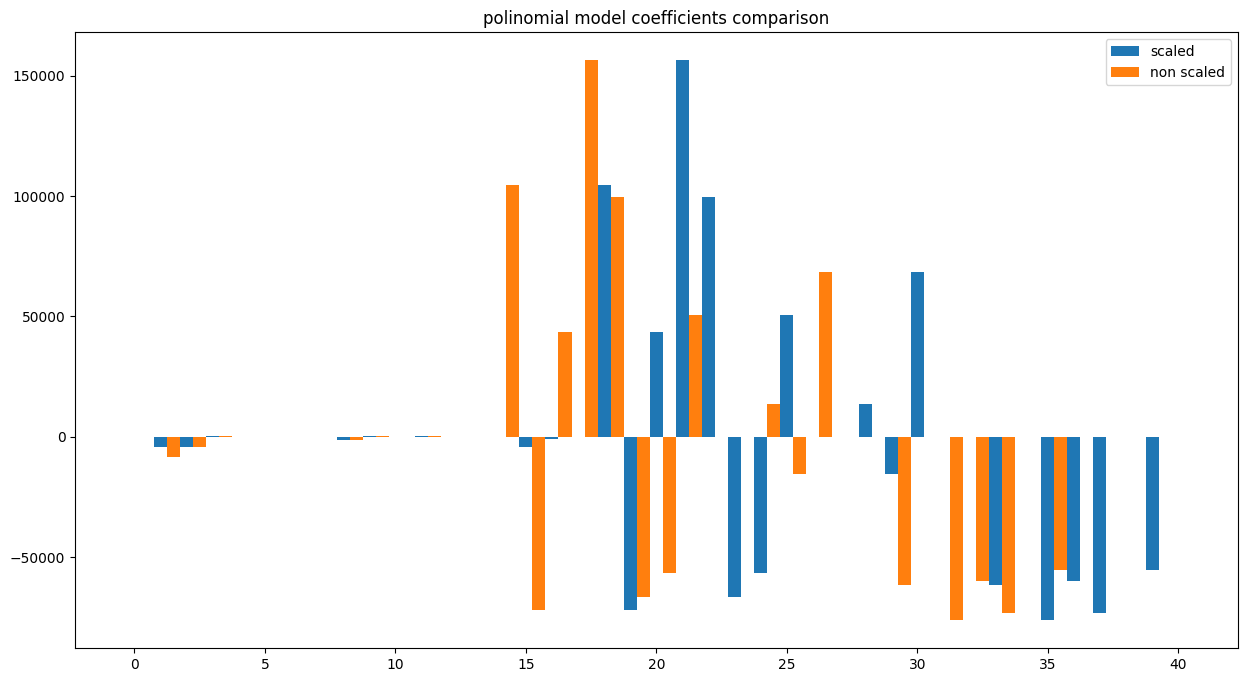

In [ ]:
scale_coef = pol_scale_model.named_steps["model"].coef_
lin_coef = pol_lin_model.named_steps["model"].coef_

width = 0.50
plt.figure(figsize=(15,8))
plt.bar(np.arange(len(scale_coef)), scale_coef, width, label="scaled")
plt.bar((np.arange(len(lin_coef)) + width), lin_coef, width, label="non scaled")
plt.legend()
plt.title("polinomial model coefficients comparison")

In [ ]:
print("mean value of the coefficients from the scaled model: ",np.abs(scale_coef).mean(), "\nmean value of the coefficients from the not scaled model: " , np.abs(lin_coef).mean(
))

mean value of the coefficients from the scaled model:  26565.59604394454 
mean value of the coefficients from the not scaled model:  29420.15760009637


Sopra si può vedere il confronto dei coefficienti dei modelli polinomiali con e senza standardizzazione dei dati.
Non si evidenziano particolari differenze ma il modello standardizzato **in media** mostra coefficienti minori in valore assoluto.  
Verrà mantenuto il modello standardizzato per il prossimo confronto.

### modello polinomiale con penalizzazione e standardizzazione features

In [ ]:
# Ridge model
rg_scale_model = Pipeline([
    ("scaler", poly_std),
    ("model", Ridge())
])

rg_scale_score = cross_val_score(rg_scale_model, x_train, y_train, scoring="r2", cv=kf).mean()
print("\nmean r2 score on train data: ", rg_scale_score, "\n\nscores on test data:")

rg_scale_model.fit(x_train, y_train)
print_scores(rg_scale_model.predict(x_val), y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.52621e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.29296e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.75131e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.47235e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



mean r2 score on train data:  0.9219724026746464 

scores on test data:
r2 score: 0.9276, mean squared error: 155893427.5563, relative error: 0.1864


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.30717e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.32427e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Confrontando i punteggi ottenuti dai modelli con e senza penalizzazione non si evidenziano differenze significative.  
Si confrontano ora i loro coefficienti.

Text(0.5, 1.0, 'polinomial model coefficients comparison')

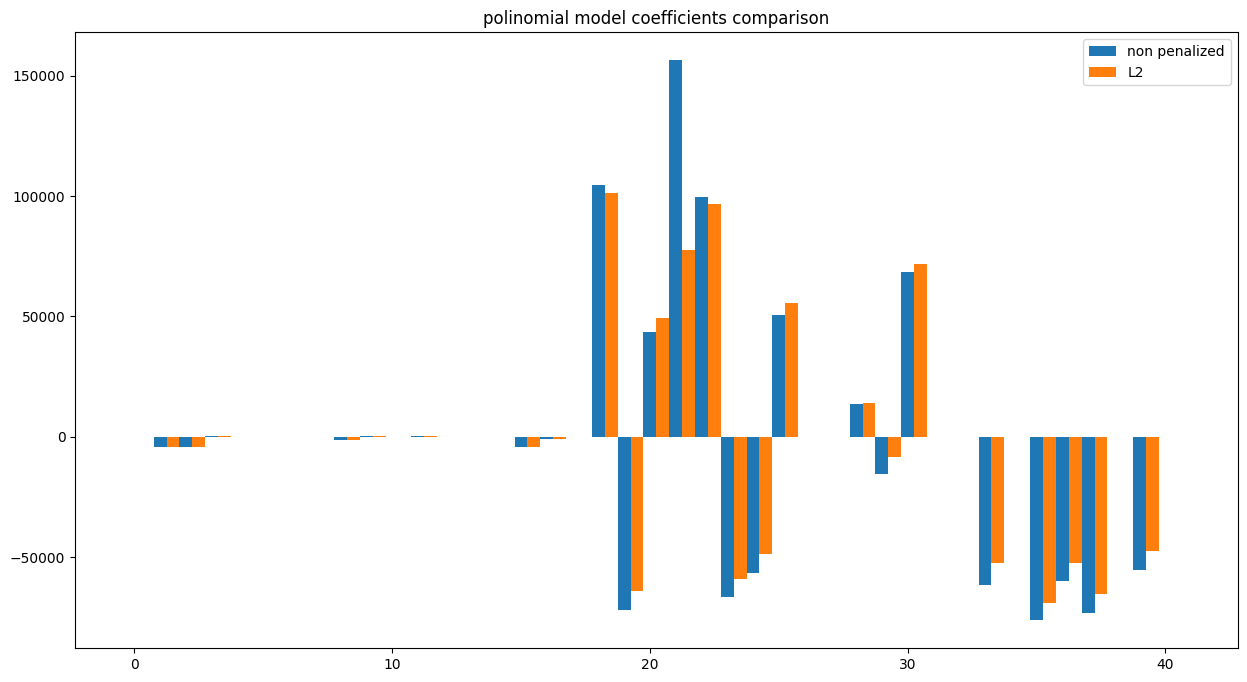

In [ ]:
rg_coef = rg_scale_model.named_steps["model"].coef_

width = 0.50
plt.figure(figsize=(15,8))
plt.bar(np.arange(len(scale_coef)), scale_coef, width, label="non penalized")
plt.bar((np.arange(len(rg_coef)) + width), rg_coef, width, label="L2")
plt.legend()
plt.title("polinomial model coefficients comparison")

In [ ]:
print("mean value of the coefficients from the model without L2 penalization: ",np.abs(scale_coef).mean(), "\nmean value of the coefficients from the model with L2 penaliztion: " , np.abs(rg_coef).mean(
))

mean value of the coefficients from the model without L2 penalization:  26565.59604394454 
mean value of the coefficients from the model with L2 penaliztion:  23129.818213030187


I valori assoluti del modello con penalizzazione sono leggermente minori in media rispetto a quelli del modello non penalizzato.  
Questo dovrebbe permette una **maggiore stabilità** delle previsioni, particolarmente su dati appartenti agli estremi dell'intervallo di addestramento.

Verrà riaddestrato il modello con penalizzazione e standardizzazione.

### grid search su modello polinomiale migliore
Si riaddestra il modello esplorando diversi parametri per:
- il filtro `PolynomialFeature`
- il modello `Ridge`

In [ ]:
# grid search on Ridge model
%%time
rg_grid = {
    "scaler__poly__degree":  range(2, 6),
    # "scaler__poly__interaction_only": [True, False],
    "model__alpha": np.linspace(0.1, 2, num=12)
}

gs = GridSearchCV(rg_scale_model, rg_grid, n_jobs=-1, cv=kf)
gs.fit(x_train, y_train);

CPU times: user 901 ms, sys: 176 ms, total: 1.08 s
Wall time: 15.8 s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.06749e-37): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


GridSearchCV(cv=KFold(n_splits=5, random_state=19, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('poly',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['kms_driven',
                                                                          'owner',
                                                                          'age',
                                                                          'power']),
                                                                        ('scaler',
                                                                         RobustScaler(),
                                                                         ['kms_driven',
                                                                          'owner',
                                                                          'age',
                                                                          'power'])])),
                                       ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': array([0.1       , 0.27272727, 0.44545455, 0.61818182, 0.79090909,
       0.96363636, 1.13636364, 1.30909091, 1.48181818, 1.65454545,
       1.82727273, 2.        ]),
                         'scaler__poly__degree': range(2, 6)})

In [ ]:
col = ["mean_test_score", "rank_test_score" ,"param_model__alpha", "param_scaler__poly__degree" ,"mean_fit_time"]
res = pd.DataFrame(gs.cv_results_)
res[col].sort_values("mean_test_score", ascending=False).head(10)

,mean_test_score,rank_test_score,param_model__alpha,param_scaler__poly__degree,mean_fit_time
13,0.932480,1,0.618182,3,0.064073
17,0.932476,2,0.790909,3,0.061060
9,0.932472,3,0.445455,3,0.062433
21,0.932464,4,0.963636,3,0.056183
5,0.932451,5,0.272727,3,0.062049
25,0.932445,6,1.136364,3,0.070410
29,0.932419,7,1.309091,3,0.112364
1,0.932412,8,0.1,3,0.068584
33,0.932388,9,1.481818,3,0.060595
37,0.932351,10,1.654545,3,0.061431


In [ ]:
gs.best_params_

{'model__alpha': 0.6181818181818182, 'scaler__poly__degree': 3}

Si può vedere come i modelli con punteggio migliore usino un modello polinomiale di **3°** grado.  
questo vuol dire che:
- aumentando ulteriormente il grado si va incontro ad *overfitting* sui dati di addestramento 
- con un grado più basso i modelli non riescono ad apprendere efficacemente i dati 

Come si può vedere sotto i modelli di 4° e 5° grado mostrano un punteggio peggiore.  

In [ ]:
res.loc[ res["param_scaler__poly__degree"] == 4 , col].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,rank_test_score,param_model__alpha,param_scaler__poly__degree,mean_fit_time
2,0.905157,25,0.1,4,0.107425
6,0.905020,26,0.272727,4,0.079233
10,0.904894,27,0.445455,4,0.086132
14,0.904783,28,0.618182,4,0.078033
18,0.904685,29,0.790909,4,0.084937


In [ ]:
res[col].sort_values("mean_test_score", ascending=False).tail(5)

,mean_test_score,rank_test_score,param_model__alpha,param_scaler__poly__degree,mean_fit_time
19,-11.108839,44,0.790909,5,0.127672
15,-11.370128,45,0.618182,5,0.122480
11,-11.678156,46,0.445455,5,0.123122
7,-12.040922,47,0.272727,5,0.128825
3,-12.547067,48,0.1,5,0.178960


Per quanto riguarda il parametro `alpha` della regressione Ridge non si nota una grande variazione del punteggio sui dati di test.  
Si possono tuttavia controllare i coefficienti per scegliere quelli in media più piccoli;  
questo dovrebbe permette delle previsioni su dati sconosciuti **più stabili**.

In [ ]:
%%time
# select best alphas and best degrees from datframe
alpha = res.sort_values("mean_test_score", ascending=False).head(8)["param_model__alpha"].tolist()
degree = res.sort_values("mean_test_score", ascending=False).head(8)["param_scaler__poly__degree"]
degree = [int(d) for d in set(degree)]

# train models with selected parameters
models = []
for d in degree:
  for a in alpha:
    col = ColumnTransformer([
        ("poly", PolynomialFeatures(degree=d, include_bias=False), x_numerical),
        ("scaler", RobustScaler(), x_numerical)
    ], remainder="passthrough")
    m = Pipeline([
        ("scaler", col),
        ("model", Ridge(alpha=a))
    ])
    m.fit(x_train, y_train)
    models.append({"m": m,
                   "a": a,
                   "d": d})

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.06749e-37): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.16004e-36): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.53435e-37): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.4133e-36): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning

CPU times: user 524 ms, sys: 478 ms, total: 1 s
Wall time: 586 ms


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.91975e-36): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.46711e-37): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
# select parameters from model with smallest coefficients on average
mdls = pd.DataFrame({
    "alpha": [m["a"] for m in models],
    "degree": [m["d"] for m in models],
    "model": [ m["m"] for m in models],
    "mean_coef": [np.abs(m["m"].named_steps["model"].coef_).mean() for m in models]
}).sort_values("mean_coef").head()
mdls

,alpha,degree,model,mean_coef
6,1.309091,3,"(ColumnTransformer(remainder='passthrough',\n ...",14975.599746
5,1.136364,3,"(ColumnTransformer(remainder='passthrough',\n ...",15224.917414
3,0.963636,3,"(ColumnTransformer(remainder='passthrough',\n ...",15499.000115
1,0.790909,3,"(ColumnTransformer(remainder='passthrough',\n ...",15804.184270
0,0.618182,3,"(ColumnTransformer(remainder='passthrough',\n ...",16149.493256


Sono stati scelti , tra i modelli con il punteggio migliore, i parametri che portano al modello con i coefficienti più piccoli in media.  

Verrà ora verificato il modello sui dati di test

In [ ]:
best_mdl = mdls["model"][mdls["mean_coef"].idxmin()]

In [ ]:
print_scores(best_mdl.predict(x_val), y_val)

r2 score: 0.9354, mean squared error: 139210744.6112, relative error: 0.1717


Il modell **polinomiale** con **standardizzazione** dei dati e **regolarizzazione ridge** dimostra un buon punteggio sui dati di test.

## modelli ad albero
Si procede con la grezione di due modelli:
- modello ad albero semplice
- modello a foresta (random forest)

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

### modello ad albero semplice
Viene addestrato un primo modello semplice senza specificare iperparametri

In [ ]:
simple_tr_mdl = DecisionTreeRegressor(random_state=_RANDOM_STATE)

str_score = cross_val_score(simple_tr_mdl, x_train, y_train, scoring="r2", cv=kf).mean()
print("mean r2 score on train data: ", str_score, "\n\nscores on test data:")

simple_tr_mdl.fit(x_train, y_train)
print_scores(simple_tr_mdl.predict(x_val), y_val)

mean r2 score on train data:  0.9567000916101241 

scores on test data:
r2 score: 0.9529, mean squared error: 101545362.9379, relative error: 0.0508


Come si può vedere l'albero di regressione dimostra già un buon punteggio, ma senza limitare la profondità dell'albero o il numero delle foglie questo può crescere molto, come si vede sotto.

In [ ]:
features = x_val.columns.tolist()
print(export_text(simple_tr_mdl, feature_names=features, max_depth=5))

|--- power <= 236.50
|   |--- age <= 5.50
|   |   |--- power <= 142.00
|   |   |   |--- KTM <= 0.50
|   |   |   |   |--- kms_driven <= 8425.50
|   |   |   |   |   |--- age <= 3.50
|   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |--- age >  3.50
|   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |--- kms_driven >  8425.50
|   |   |   |   |   |--- age <= 4.50
|   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |   |--- age >  4.50
|   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |--- KTM >  0.50
|   |   |   |   |--- kms_driven <= 611.50
|   |   |   |   |   |--- kms_driven <= 70.00
|   |   |   |   |   |   |--- value: [152000.00]
|   |   |   |   |   |--- kms_driven >  70.00
|   |   |   |   |   |   |--- value: [178000.00]
|   |   |   |   |--- kms_driven >  611.50
|   |   |   |   |   |--- age <= 2.50
|   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |--- age >  2.50
|   

In [ ]:
simple_tr_mdl.get_depth()

28

Dall'addestrametno viene generato un albero molto profondo.  
Si prosegue con una grid search per cercare di ottenere un albero meno profondo ma che abbia comunque un buon punteggio.

In [ ]:
%%time
# fit takes about 1 min
t_grid = {
    "max_depth": range(9, 17),
    "min_samples_split": np.linspace(0.0001, 0.001, 20, dtype=float),
    "min_samples_leaf": range(2,5)
}

tgs = GridSearchCV(simple_tr_mdl, t_grid, n_jobs=-1, cv=kf)
tgs.fit(x_train, y_train)

CPU times: user 3.36 s, sys: 431 ms, total: 3.79 s
Wall time: 1min 4s


GridSearchCV(cv=KFold(n_splits=5, random_state=19, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=19), n_jobs=-1,
             param_grid={'max_depth': range(9, 17),
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': array([0.0001    , 0.00014737, 0.00019474, 0.00024211, 0.00028947,
       0.00033684, 0.00038421, 0.00043158, 0.00047895, 0.00052632,
       0.00057368, 0.00062105, 0.00066842, 0.00071579, 0.00076316,
       0.00081053, 0.00085789, 0.00090526, 0.00095263, 0.001     ])})

In [ ]:
col = ["mean_test_score", "rank_test_score" ,"params" ,"mean_fit_time"]
res = pd.DataFrame(tgs.cv_results_)
res[col].sort_values("mean_test_score", ascending=False).head(10)

,mean_test_score,rank_test_score,params,mean_fit_time
337,0.962478,1,"{'max_depth': 14, 'min_samples_leaf': 3, 'min_...",0.039881
275,0.962472,2,"{'max_depth': 13, 'min_samples_leaf': 3, 'min_...",0.043301
135,0.962424,3,"{'max_depth': 11, 'min_samples_leaf': 2, 'min_...",0.041745
397,0.962397,4,"{'max_depth': 15, 'min_samples_leaf': 3, 'min_...",0.039599
457,0.962397,5,"{'max_depth': 16, 'min_samples_leaf': 3, 'min_...",0.050203
217,0.962311,6,"{'max_depth': 12, 'min_samples_leaf': 3, 'min_...",0.038512
317,0.962303,7,"{'max_depth': 14, 'min_samples_leaf': 2, 'min_...",0.039681
339,0.962219,8,"{'max_depth': 14, 'min_samples_leaf': 3, 'min_...",0.039320
338,0.962219,8,"{'max_depth': 14, 'min_samples_leaf': 3, 'min_...",0.040786
278,0.962208,10,"{'max_depth': 13, 'min_samples_leaf': 3, 'min_...",0.039892


In [ ]:
print_scores(tgs.predict(x_val), y_val)

r2 score: 0.9613, mean squared error: 83365925.4397, relative error: 0.0548



Rispetto ai modelli polinomiali gli alberi decisionali hanno il vantaggio di essere facilmente interpretabili.  
Infatti vedendo sia l'albero generato con l'addestramento, come visto sopra, sia il "*valore di importanza*" delle colonne, si può comprendere quali siano le caratteristiche fondamentali dei dati per una buona previsione.

Sotto sono mostrati i valori di importanza attribuiti alle variabili in input in ordine crescente; questi sono legati al numero di split eseguiti sulle caratteristiche presenti nell'albero.  
Si può vedere come le colonne più importanti siano **power** e **age**.  


In [ ]:
pd.Series(tgs.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)

power              0.687628
age                0.135459
Royal Enfield      0.097655
kms_driven         0.050783
KTM                0.010019
Yamaha             0.005419
Bajaj              0.003632
Hyosung            0.003054
Mahindra           0.002128
Honda              0.002120
BMW                0.001196
owner              0.000298
Hero               0.000280
Suzuki             0.000207
TVS                0.000122
MV                 0.000000
Triumph            0.000000
Rajdoot            0.000000
Indian             0.000000
LML                0.000000
Kawasaki           0.000000
Jawa               0.000000
Ideal              0.000000
Harley-Davidson    0.000000
Ducati             0.000000
Benelli            0.000000
Yezdi              0.000000
dtype: float64

Dall'importanza delle caratteristiche si può notare anche come alcune colonne categoriche, in particolare *Royal Enfield* e *KTM* siano considerate più importanti delle altre.  
Questi sbilanciamenti sono dovuti al numero di dati legati ad un prduttore che sono in numero maggiore rispetto ad altri.  
questo problema viene detto **sbilanciamento delle classi**.
Un metodo per migliorare la dipendenza dai dati può essere l'uso di una foresta di regressione.

### modello bagging
Un modello random forest addestra più alberi su sottoinsiemi non disgiunti delle colonne dei dati; esegue poi le previsioni come media delle previsioni dei singoli alberi.  
Segue un primo addestramento di una foresta di regressione.

In [ ]:
rf_mdl = RandomForestRegressor(random_state=_RANDOM_STATE)

rf_score = cross_val_score(rf_mdl, x_train, y_train, scoring="r2", cv=kf).mean()
print("mean r2 score on train data: ", rf_score, "\n\nscores on test data:")

rf_mdl.fit(x_train, y_train)
print_scores(rf_mdl.predict(x_val), y_val)

mean r2 score on train data:  0.9685503065343667 

scores on test data:
r2 score: 0.9669, mean squared error: 71305895.4099, relative error: 0.0477


In [ ]:
pd.Series(rf_mdl.feature_importances_, index=features).sort_values(ascending=False)

power              0.667281
age                0.138245
Royal Enfield      0.095736
kms_driven         0.066235
KTM                0.009976
Yamaha             0.007028
Bajaj              0.003207
Honda              0.002045
BMW                0.002001
Hyosung            0.001918
Mahindra           0.001420
owner              0.001325
Benelli            0.001319
Kawasaki           0.000939
TVS                0.000589
Hero               0.000328
Suzuki             0.000269
Harley-Davidson    0.000111
Jawa               0.000026
Ducati             0.000004
Triumph            0.000000
Indian             0.000000
Rajdoot            0.000000
MV                 0.000000
LML                0.000000
Ideal              0.000000
Yezdi              0.000000
dtype: float64

Si può ancora vedere l'effetto dello sbilanciamento delle classi.

Si procede ad una ricerca degli iperparametri per migliorare l'indipendenza dai dati di addestramento; in particolare grazie all'iperparametro `max_features` che limita il numero di dati usati per la divisione di un nodo ad un sottoinsieme casuale delle colonne del training set.

In [ ]:
%%time
# fit takes about 3 min
rf_grid = {
    "max_depth": range(8, 15, 3),
    "min_samples_split": [5,9,12],
    "min_samples_leaf": [1,3,5],
    "n_estimators": [50],# [50, 100, 150],
    "max_features": range(10, int(len(features)/2)+4, 3)
}

rfgs = GridSearchCV(rf_mdl, rf_grid, n_jobs=-1, cv=kf)
rfgs.fit(x_train, y_train)

CPU times: user 3.12 s, sys: 309 ms, total: 3.43 s
Wall time: 2min 58s


GridSearchCV(cv=KFold(n_splits=5, random_state=19, shuffle=True),
             estimator=RandomForestRegressor(random_state=19), n_jobs=-1,
             param_grid={'max_depth': range(8, 15, 3),
                         'max_features': range(10, 17, 3),
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [5, 9, 12],
                         'n_estimators': [50]})

In [ ]:
col = ["mean_test_score", "rank_test_score" ,"params" ,"mean_fit_time"]
res = pd.DataFrame(rfgs.cv_results_)
res[col].sort_values("mean_test_score", ascending=False)

,mean_test_score,rank_test_score,params,mean_fit_time
63,0.969854,1,"{'max_depth': 14, 'max_features': 13, 'min_sam...",0.860151
72,0.969693,2,"{'max_depth': 14, 'max_features': 16, 'min_sam...",1.531968
73,0.969339,3,"{'max_depth': 14, 'max_features': 16, 'min_sam...",0.909786
54,0.969204,4,"{'max_depth': 14, 'max_features': 10, 'min_sam...",1.278942
64,0.969143,5,"{'max_depth': 14, 'max_features': 13, 'min_sam...",0.818925
...,...,...,...,...
3,0.953303,77,"{'max_depth': 8, 'max_features': 10, 'min_samp...",0.588935
5,0.952731,78,"{'max_depth': 8, 'max_features': 10, 'min_samp...",0.666502
7,0.951858,79,"{'max_depth': 8, 'max_features': 10, 'min_samp...",0.570635
6,0.951858,79,"{'max_depth': 8, 'max_features': 10, 'min_samp...",0.569794


In [ ]:
print_scores(rfgs.predict(x_val), y_val)

r2 score: 0.9705, mean squared error: 63617818.4255, relative error: 0.0488


In [ ]:
pd.Series(rfgs.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)

power              0.530473
age                0.204523
kms_driven         0.087615
Royal Enfield      0.060060
KTM                0.048712
Harley-Davidson    0.021728
Hero               0.012512
Yamaha             0.006966
Bajaj              0.006751
Kawasaki           0.003542
owner              0.003492
Hyosung            0.003424
BMW                0.002637
Honda              0.002359
Benelli            0.001947
TVS                0.001428
Mahindra           0.001035
Suzuki             0.000641
Ducati             0.000100
Jawa               0.000055
Triumph            0.000000
Indian             0.000000
Rajdoot            0.000000
MV                 0.000000
LML                0.000000
Ideal              0.000000
Yezdi              0.000000
dtype: float64

Il modello così addestrato attribuisce un'importanza relativamente minore alle variabili categoriche sbilanciate rispetto all'albero di regressione semplice; questo dovrebbe portare ad una predizione migliore su dati sconosciuti.  
Il modello mantiene comunque un buon punteggio sui dati di test.  

## modello catboost
Segue l'addestrare di un modello da una libreria esterna.  
Viene usato [CatBoost](https://catboost.ai/) perchè, a differenza dell'implementazione degli alberi di scikit learn, accetta dati con colonne di tipo categorico; questo semplifica la preparazione dei dati.

Inoltre CatBoost, a differenza della foresta di regressione usata sopra, usa una tecnica detta **boosting**;  
con quessta tecnica ad ogni iterazione si addestra un nuovo albero da aggiungere al modello; l'albero da aggiungere all'iterazione successiva viene addestrato sugli errori di predizione dell'iterazione corrente.  
Si possono quindi confrontare i risultati di due tipi di foreste di regressione diverse.

Vengono ora caricati i dati con valori categorici (senza encoding)

In [ ]:
x_train_cat, x_val_cat, _, _ = train_test_split(x, y, test_size=_TEST_SIZE, random_state=_RANDOM_STATE)
x_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21211 entries, 4618 to 31094
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   kms_driven  21211 non-null  float64 
 1   owner       21211 non-null  category
 2   age         21211 non-null  int64   
 3   power       21211 non-null  float64 
 4   brand       21211 non-null  category
dtypes: category(2), float64(2), int64(1)
memory usage: 705.2 KB


In [ ]:
%pip install catboost
import catboost
from catboost import CatBoostRegressor, cv, Pool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
cat_train = Pool(x_train_cat, y_train, cat_features=categorical_left)
cat_val = Pool(x_val_cat, y_val, cat_features=categorical_left)

In [ ]:
cb_mdl = CatBoostRegressor(iterations=100, loss_function="RMSE", cat_features=categorical_left, verbose=False, task_type="CPU")
cb_mdl.fit(cat_train, verbose=False)

cb_score = cross_val_score(cb_mdl, x_train_cat, y_train, scoring="r2", cv=kf).mean()

print("mean r2 score on train data: ", cb_score, "\n\nscores on test data:")
print_scores(cb_mdl.predict(x_val_cat), y_val)

mean r2 score on train data:  0.9682306196584902 

scores on test data:
r2 score: 0.9659, mean squared error: 73540087.6129, relative error: 0.0623


Si può vedere come CatBoost ottenga un ottimo punteggio specificando solo alcuni iperparametri.  
Si esegue ora una ricerca per migliorare il modello prima di analizzarne le caratteristiche. 

In [ ]:
%%time
# fit takes about 6 min
cb_grid = {
    "iterations": [100, 150, 200],
    # "learning_rate": [0.3, 0.6, 1] # not set beacuse defined automatically for RMSE
    "grow_policy": ["Depthwise", "Lossguide"], # ["SymmetricTree", "Depthwise", "Lossguide"], # not much difference is shown
    "depth": [15] # [6, 10, 15],
}

cbgs = GridSearchCV(cb_mdl, cb_grid, n_jobs=-1, cv=kf)
cbgs.fit(x_train_cat, y_train)

CPU times: user 7.62 s, sys: 864 ms, total: 8.48 s
Wall time: 5min 45s


GridSearchCV(cv=KFold(n_splits=5, random_state=19, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc0d289ca60>,
             n_jobs=-1,
             param_grid={'depth': [15],
                         'grow_policy': ['Depthwise', 'Lossguide'],
                         'iterations': [100, 150, 200]})

In [ ]:
res = pd.DataFrame(cbgs.cv_results_)
res[col].sort_values("mean_test_score", ascending=False)

,mean_test_score,rank_test_score,params,mean_fit_time
5,0.971064,1,"{'depth': 15, 'grow_policy': 'Lossguide', 'ite...",5.915760
4,0.970263,2,"{'depth': 15, 'grow_policy': 'Lossguide', 'ite...",4.719004
3,0.969716,3,"{'depth': 15, 'grow_policy': 'Lossguide', 'ite...",3.158218
1,0.966867,4,"{'depth': 15, 'grow_policy': 'Depthwise', 'ite...",40.212172
2,0.966301,5,"{'depth': 15, 'grow_policy': 'Depthwise', 'ite...",52.083180
0,0.966018,6,"{'depth': 15, 'grow_policy': 'Depthwise', 'ite...",28.370136


In [ ]:
print_scores(cbgs.predict(x_val_cat), y_val)

r2 score: 0.9678, mean squared error: 69325702.6573, relative error: 0.0548


La ricerca degli iperparametri ha permesso di trovare un modello con un punteggio miglior, senza aumentare di molto il numero di iterazioni, ovvero il numero di alberi addestrati.

In [ ]:
pd.Series(cbgs.best_estimator_.get_feature_importance(), index=x_val_cat.columns.tolist()).sort_values(ascending=False)

power         70.843083
age           14.250047
brand          7.488565
kms_driven     7.039024
owner          0.379281
dtype: float64

Si può notare come l'importanza assegnata alle colonne sia in linea con quella assegnata dal modello random forest.  
(in ordine: *power* > *age* > *kms_driven* > *brand* )

# conclusioni

## confronto modelli migliori

In [ ]:
lin_score = r2_score(lin_mdl.predict(x_val), y_val)
pol_score = r2_score(best_mdl.predict(x_val), y_val)
for_score = r2_score(rfgs.predict(x_val), y_val)
cbo_score = r2_score(cbgs.predict(x_val_cat), y_val)
scores = [lin_score, pol_score, for_score, cbo_score]
models = ["linear regressor", "standardized ridge regressor", "random forest regressor", "catboost regressor"]

pd.Series(scores, index=models).sort_values(ascending=False)

random forest regressor         0.969780
catboost regressor              0.967433
standardized ridge regressor    0.931419
linear regressor                0.877093
dtype: float64

Come si può vedere sopra RandomForest ha ottenuto il punteggio migliore tra i modelli creati.  
Il modello CatBoost ha però ottenuto un punteggio molto simile ma usando quattro volte gli alberi addestrati dal modello di boosting.

Ovviamente i modelli *ensemble learning* hanno "battuto" i modelli polinomiale e lineare ma il modello Ridge ha ottenuto comunque un buon punteggio; questo modello ha il pregio di richiede meno risorse, soprattutto durante l'addestramento, rispetto ai modelli ad albero. 

## possibili approfondimenti

Per migliorare la previsione sui dati si potrebbe:
- provare il comportamento di modelli basati su funzioni kernel
- generare nuovi dati per migliorare lo sbilanciamento delle classe in *brand* (la casa produttrice)
- processare il campo testuale "*bike_name*", scartato in fase di preprocessamento, e verificare se sia possibile ottenere informazioni aggiuntive